In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score , RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression


import shap
from shap import LinearExplainer



# 0. Set preliminaries

In [2]:
# Define the scoring metric with the positive label specified
# Depression = 1
scorer = make_scorer(f1_score, pos_label=1) 

In [3]:
# Set display settings: Turning off scientific notation and getting max column width displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# 1. Load in the dataset

In [26]:
df = pd.read_csv('../Data/Combined_sets/data_rq1.tsv', header=[0,1], index_col=[0], sep='\t')

In [6]:
columns_list = df.columns.to_list()
# Remove the label column
columns_list = columns_list[:-1]

In [7]:
# Check
print(columns_list)

[('gender', 'male'), ('gender', 'female'), ('age', '19-29'), ('age', '30-39'), ('age', '<=18'), ('age', '>=40'), ('Affect', 'mean_NA'), ('Affect', 'NAV'), ('Affect', 'mean_affect'), ('Affect', 'AV'), ('Affect', 'mean_PA'), ('Affect', 'PAV'), ('Tweet_Count', 'timeline'), ('Tweet_Count', 'sd_words'), ('Tweet_Count', 'min_words'), ('Tweet_Count', 'max_words'), ('Tweet_Count', 'mean_punct'), ('Tweet_Count', 'mean_exclam'), ('Tweet_Count', 'log_punct'), ('Tweet_Count', 'log_exclam'), ('Tweet_Count', 'mentions_p'), ('Emojis', 'mean_emoji'), ('Emojis', 'log_total_emoji'), ('Emojis', 'neg_emoji_p'), ('Emojis', 'pos_emoji_p'), ('CDS_prevalence', 'labeling_mislabeling'), ('CDS_prevalence', 'catastrophising'), ('CDS_prevalence', 'dichotomous_reasoning'), ('CDS_prevalence', 'emotional_reasoning'), ('CDS_prevalence', 'disqualifying_positive'), ('CDS_prevalence', 'magnification_minimisation'), ('CDS_prevalence', 'mental_filtering'), ('CDS_prevalence', 'mindreading'), ('CDS_prevalence', 'fortunetelli

In [8]:
df = df.fillna(0)

# 2. Dataset split and scaling

In [9]:
y = df[("target", "diagnosis")]
X = df.drop([("target", "diagnosis")], axis=1)

In [10]:
# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)


## 2.2 Scaling

In [11]:
# Initialize the MinMaxScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data using the scaler fitted on the training data
X_test = scaler.transform(X_test)


# 3. Logistic Regression Performance

We used RandomizedSearchCV, so to control for the randomization, we set n_iter to 100 and repeated the model fit 10 times, then taking the best result and hyperparameters from those.

### 1

In [12]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 2

In [13]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 3

In [14]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 4

In [15]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 5

In [16]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 6

In [ ]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 7

In [ ]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 8

In [ ]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 9

In [ ]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.001}
Best f1 score found:  0.6395449371406867
Test accuracy of the best Logistic Regression model:  0.6305555555555555
Test precision of the best Logistic Regression model:  0.6267942583732058
Test recall of the best Logistic Regression model:  0.7043010752688172
Test f1 score of the best Logistic Regression model:  0.6632911392405063


### 10

In [ ]:
# Initialise the Logistic Regression model
lr = LogisticRegression(random_state=42, solver='lbfgs') 

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.01],
    'max_iter': [2000],
    'penalty': ['l2']
}

# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    scoring=scorer, 
    n_iter=100,
    random_state=42,
    cv=skf,
    verbose=1,
    n_jobs=-1  
)

# Fit RandomizedSearchCV to the training data
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search_lr.best_params_)
print("Best f1 score found: ", random_search_lr.best_score_)

# Evaluate the best model on the test data
best_lr_model = random_search_lr.best_estimator_
y_test_pred_lr = best_lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_test_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_test_pred_lr, pos_label=1)


print("Test accuracy of the best Logistic Regression model: ", accuracy_lr)
print("Test precision of the best Logistic Regression model: ", precision_lr)
print("Test recall of the best Logistic Regression model: ", recall_lr)
print("Test f1 score of the best Logistic Regression model: ", f1_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'penalty': 'l2', 'max_iter': 2000, 'C': 0.01}
Best f1 score found:  0.6322754480433153
Test accuracy of the best Logistic Regression model:  0.6444444444444445
Test precision of the best Logistic Regression model:  0.6510416666666666
Test recall of the best Logistic Regression model:  0.6720430107526881
Test f1 score of the best Logistic Regression model:  0.6613756613756614


Confusion Matrix

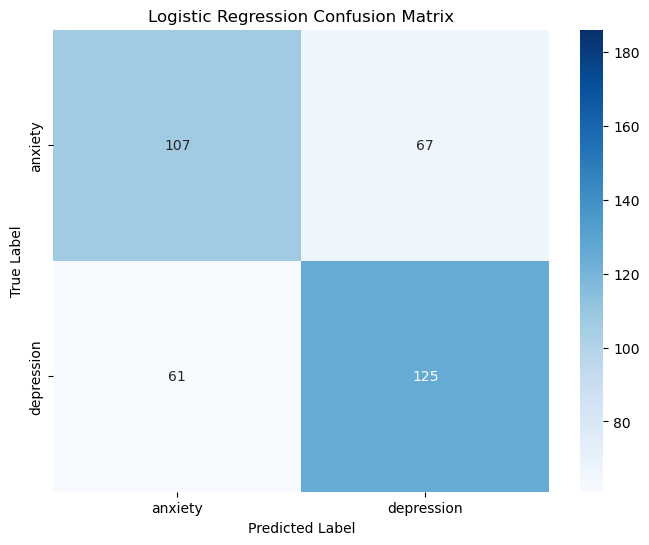

In [22]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_lr, labels=[0, 1])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['anxiety', 'depression'], yticklabels=['anxiety', 'depression'],vmax=186)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# RQ2: Feature importances

SHAP calculation with LinearExplainer

In [23]:
# explain all the predictions in the test set
explainer_lr = shap.LinearExplainer(best_lr_model, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)

Beeswarm plot for positive depression class, top 20

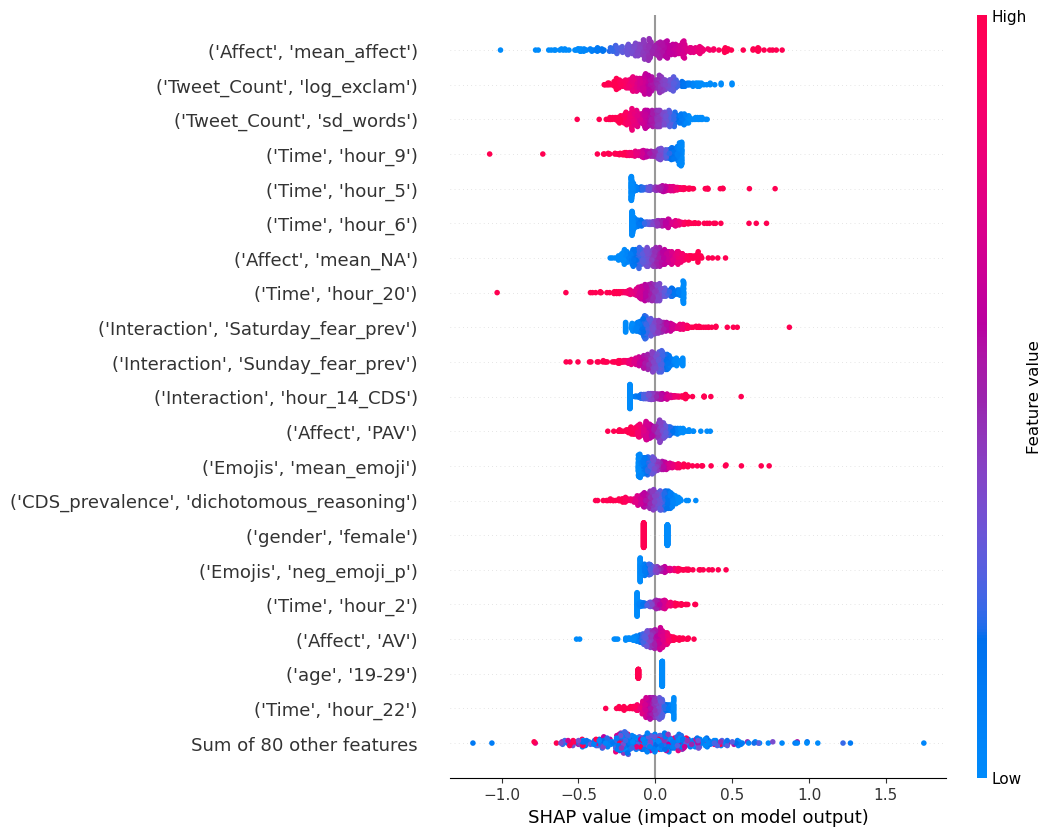

In [24]:

# Get feature names from X_train.columns (assuming X_train is a DataFrame)
feature_names_lr = columns_list

# Ensure shap_values_rf is a list of arrays for binary classification
# and we select the values for the 'depression' class = 1
if isinstance(shap_values_lr, list) and len(shap_values_lr) == 2:

    values_for_plot_lr = shap_values_lr[1]
    base_value_lr = explainer_lr.expected_value[1]
else:

    values_for_plot_lr = shap_values_lr
    base_value_lr = explainer_lr.expected_value

# Create a shap.Explanation object
shap_explanation_lr = shap.Explanation(
    values=values_for_plot_lr,
    base_values=base_value_lr,
    data=X_test, # Convert DataFrame to numpy array if X_test is a DataFrame
    feature_names=feature_names_lr
)

# Now call shap.plots.beeswarm with the Explanation object
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_explanation_lr, max_display=21)

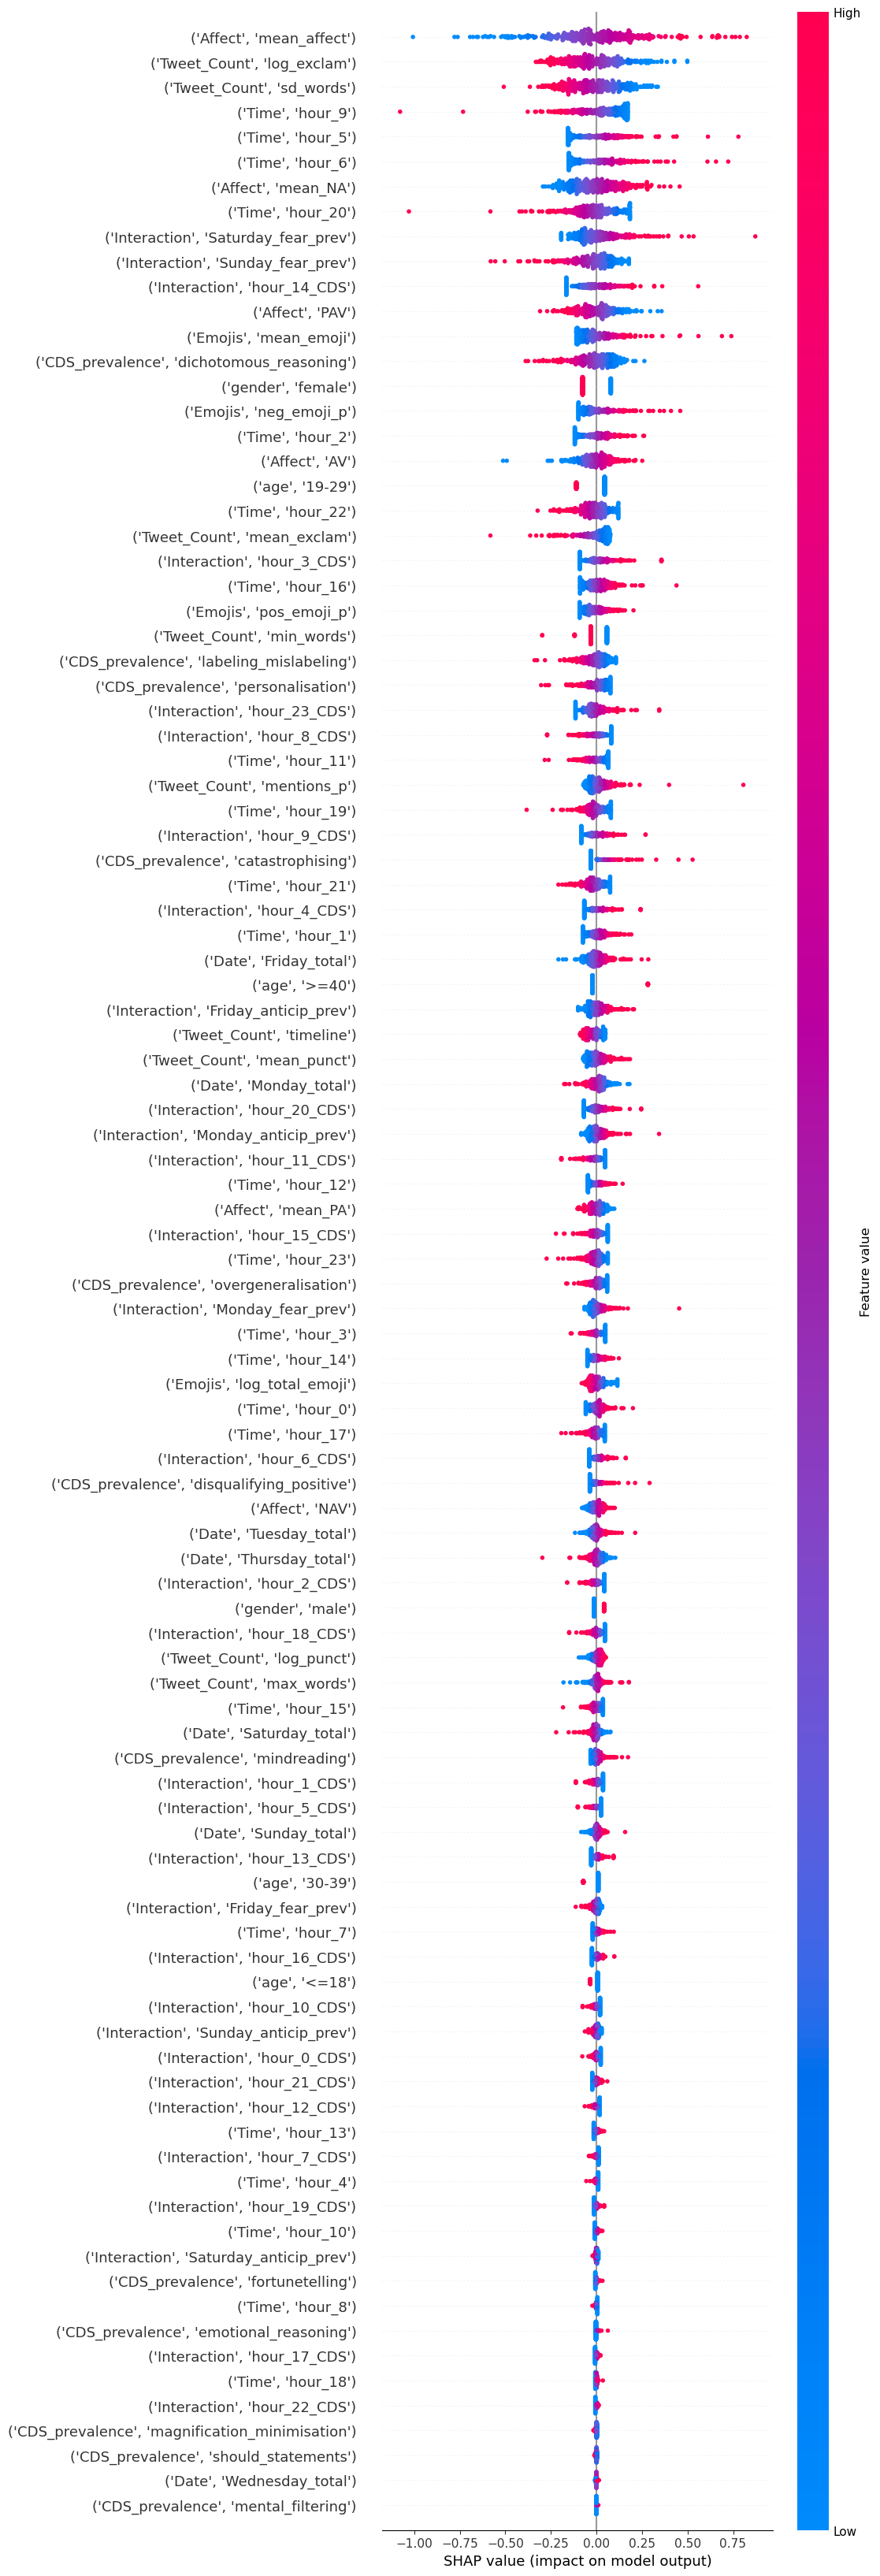

In [25]:
# Get feature names from X_train.columns (assuming X_train is a DataFrame)
feature_names_lr = columns_list

# Ensure shap_values_rf is a list of arrays for binary classification
# and we select the values for the 'depression' class = 1
if isinstance(shap_values_lr, list) and len(shap_values_lr) == 2:
    values_for_plot_lr = shap_values_lr[1]
    base_value_lr = explainer_lr.expected_value[1]
else:
    values_for_plot_lr = shap_values_lr
    base_value_lr = explainer_lr.expected_value

# Create a shap.Explanation object
shap_explanation_lr = shap.Explanation(
    values=values_for_plot_lr,
    base_values=base_value_lr,
    data=X_test, # Convert DataFrame to numpy array if X_test is a DataFrame
    feature_names=feature_names_lr
)

# Now call shap.plots.beeswarm with the Explanation object
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_explanation_lr, max_display=100)